In [4]:
from __future__ import division,print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.stats
from scipy.stats import norm
from scipy.optimize import curve_fit

In [151]:
def line(x,m,b):
    x = np.array(x)
    return m*x + b

def line2(x,m):
    x = np.array(x)
    return m*x

def poly(x,a,b,c):
    x = np.array(x)
    return a*x**2 + b*x + c

def gaus(x,x0,a,sigma):
    x = np.array(x)
    return a * np.exp(-(x-x0)**2 / (2*sigma**2))

def plotProfileHist(x,y,adcRange,label,color):
    means_result = scipy.stats.binned_statistic(x, [y,y**2], bins=20, range=adcRange, statistic='mean')
    means, means2 = means_result.statistic
    standard_deviations = np.sqrt(means2 - means**2)
    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    plt.errorbar(x=bin_centers, y=means, yerr=standard_deviations, fmt='o',label=label,color=color,capsize=3)
    return bin_centers, means, standard_deviations

def plotMedianHist(x,y,range,label,color):
    means_result = scipy.stats.binned_statistic(x, y, bins=20, range=range, statistic='median')
    means = means_result.statistic
    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    plt.scatter(x=bin_centers, y=means, label=label,color=color)
    return bin_centers, means

def fitRange(fracErrorVecTest,low,high):
    fracErrorVecTestRanged = []
    for i in range(len(fracErrorVecTest)):
        if fracErrorVecTest[i] <= high and fracErrorVecTest[i] >= low:
              fracErrorVecTestRanged.append(fracErrorVecTest[i])
    #return norm.fit(fracErrorVecTestRanged)
    fig = plt.figure()
    n,b,p = plt.hist(fracErrorVecTestRanged,30,range=(low,high),density=True);
    plt.show()
    plt.close(fig)
    centers = 0.5*(b[1:] + b[:-1])
    return curve_fit(lambda x, mu, sig : norm.pdf(x,loc=mu,scale=sig),centers,n,p0=[high/2,high/2])
    #return curve_fit(lambda x, mu, sig, N : N*norm.pdf(x,loc=mu,scale=sig),centers,n,p0=[high/2,high/2,max(n)])
    
def plotGausFitHist(x,y,eMax,label,color, windowFrac, ADCmin, ADCmax, plot=False, errFudge=1.0):
    bins = 20
    bin_centers = []
    means = []
    std_devs = []
    for i in range(bins):
        binMin = ADCmin + i*((ADCmax-ADCmin) / bins)
        binMax = ADCmin + (i+1)*((ADCmax-ADCmin) / bins)
        fitData = []
        bin_centers.append((binMin + binMax)/2)
        for j in range(len(x)):
            _x = x[j]
            if ((_x >= binMin) and (_x < binMax)):
                fitData.append(y[j])
        fitLow = (i/bins)*((1-windowFrac)*eMax)
        fitHigh = fitLow + windowFrac*eMax
        print("in gaus", fitData)
        pars, cov = fitRange(fitData,fitLow,fitHigh)
        mu, sigma = pars[0],np.sqrt(cov[0,0])
        #print(mu,'+-',sigma)
        
        if(plot):
            n, _bins, patches = plt.hist(fitData,50,density=True,color='r',range=(0,eMax),histtype='step')
            _y = norm.pdf(np.arange(_bins[0],_bins[-1],10),pars[0],pars[1])
            plt.title('ADC Range: %i to %i' %(binMin,binMax))
            plt.xlabel('True Electron Energy [MeV]')
            plt.plot(np.arange(_bins[0],_bins[-1],10),_y,'r--',linewidth=2)
            plt.show()
        
        
        means.append(mu)
        std_devs.append(sigma*errFudge)
        
    plt.errorbar(x=bin_centers, y=means, yerr=std_devs, fmt='.k',label=label,capsize=3,color='r')
    return bin_centers, means, std_devs

def plotFracResGausFitHist(x,y,Emin,Emax):
    bins = 20
    bin_centers = []
    means = []
    means_err = []
    std_devs = []
    std_devs_err = []
    for i in range(bins):
        binMin = Emin + i*((Emax-Emin) / bins)
        binMax = Emin + (i+1)*((Emax-Emin) / bins)
        fitData = []
        bin_centers.append((binMin + binMax)/2)
        for j in range(len(x)):
            _x = x[j]
            if ((_x >= binMin) and (_x < binMax)):
                fitData.append(y[j])
        pars, cov = fitRange(fitData,-1,2)
        mu, sigma = pars[0],pars[1]
        muerr,sigmaerr = np.sqrt(cov[0,0]),np.sqrt(cov[1,1])
        
        means.append(mu)
        means_err.append(muerr)
        std_devs.append(sigma)
        std_devs_err.append(sigmaerr)
        
    return bin_centers, means, std_devs, means_err, std_devs_err

def plotMPV(x,y,eMax,label,color, windowFrac, ADCmin, ADCmax):
    bins = 20
    bin_centers = []
    means = []
    std_devs_low = []
    std_devs_high = []
    errs = []
    for i in range(bins):
        binMin = ADCmin + i*((ADCmax-ADCmin) / bins)
        binMax = ADCmin + (i+1)*((ADCmax-ADCmin) / bins)
        fitData = []
        bin_centers.append((binMin + binMax)/2)
        for j in range(len(x)):
            _x = x[j]
            if ((_x >= binMin) and (_x < binMax)):
                fitData.append(y[j])
        
        fig = plt.figure()
        n, _bins, patches = plt.hist(fitData,100,density=True,color='r',range=(0,2*eMax),histtype='step')
        plt.clf()
        plt.cla()
        plt.close(fig)
        bc = 0.5*(_bins[0:-1]+_bins[1:])
        mu = bc[np.argmax(n)]
        firstSide = False
        secondSide = False
        fs = -1
        ss = -1
        for i,d in enumerate(n):
            if not firstSide and d > np.max(n)/2:
                fs = bc[i]
                firstSide = True
            if firstSide and not secondSide and d < np.max(n)/2:
                ss = bc[i]
                secondSide = True
        
        
        means.append(mu)
        std_devs_low.append(fs)
        std_devs_high.append(ss)
        errs.append(np.std(np.array(fitData))/np.sqrt(len(fitData)))
        
    mns = 0.5*(np.array(std_devs_low) + np.array(std_devs_high))
    std = np.array(std_devs_high)-mns
    plt.errorbar(x=bin_centers, y=means, yerr=errs, fmt='.k',label=label,capsize=3,color='r')
    return bin_centers, means, errs

def plotMG(x,y,eMax,label,color,windowFrac, ADCmin, ADCmax):
    bins = 20
    bin_centers = []
    means = []
    errs = []
    for i in range(bins):
        binMin = ADCmin + i*((ADCmax-ADCmin) / bins)
        binMax = ADCmin + (i+1)*((ADCmax-ADCmin) / bins)
        fitData = []
        bin_centers.append((binMin + binMax)/2)
        for j in range(len(x)):
            _x = x[j]
            if ((_x >= binMin) and (_x < binMax)):
                fitData.append(y[j])
        
        
        means.append(np.mean(np.array(fitData)))
        errs.append(np.std(np.array(fitData))/np.sqrt(len(fitData)))
        

    plt.errorbar(x=bin_centers, y=means, yerr=errs, fmt='.k',label=label,capsize=3,color='r')
    return bin_centers, means, errs

def getErecoOld(qU,qV,qY):
    return qU*0.0139 + 31.5,qV*0.0143 + 35.7,qY*0.0125 + 13.8

def getErecoOldY(qY):
    return 0.013456*qY + 2.06955

def getEreco(qU,qV,qY):
    return 0.0155481*qU,0.01586385*qV,0.01319672*qY

def getErecoSelOnly(qU,qV,qY):
    return 0.01492218*qU,0.01533911*qV,0.01255796*qY
    
def getErecoPoly(qU,qV,qY):
    return poly(qU,8.95228723e-10, 1.50690814e-02, 1.56982711e+01), \
           poly(qV,-2.11542238e-09, 1.56626467e-02, 1.15464447e+01), \
           poly(qY,3.64375818e-08, 1.07069173e-02, 3.87865989e+01), \

def getErecoMPV(qU,qV,qY):
    return 0.01462882*qU,0.01513484*qV,0.01212416*qY


In [152]:
# sel_r1     = list(np.array(np.loadtxt('SelectedTextFiles/run1_intrinsics_selected.txt')[:,0:5],dtype=float))
# sel_r2     = list(np.array(np.loadtxt('SelectedTextFiles/run2_intrinsics_selected.txt')[:,0:5],dtype=float))
# sel_r3     = list(np.array(np.loadtxt('SelectedTextFiles/run3_intrinsics_selected.txt')[:,0:5],dtype=float))
# sel_low_r1 = list(np.array(np.loadtxt('SelectedTextFiles/run1_intrinsics_lowE_selected.txt')[:,0:5],dtype=float))
# sel_low_r3 = list(np.array(np.loadtxt('SelectedTextFiles/run3_intrinsics_lowE_selected.txt')[:,0:5],dtype=float))

# enu_r1     = list(np.array(np.loadtxt('SelectedTextFiles/run1_intrinsics_selected.txt')[:,4],dtype=float))
# enu_r2     = list(np.array(np.loadtxt('SelectedTextFiles/run2_intrinsics_selected.txt')[:,4],dtype=float))
# enu_r3     = list(np.array(np.loadtxt('SelectedTextFiles/run3_intrinsics_selected.txt')[:,4],dtype=float))
# enu_low_r1 = list(np.array(np.loadtxt('SelectedTextFiles/run1_intrinsics_lowE_selected.txt')[:,4],dtype=float))
# enu_low_r3 = list(np.array(np.loadtxt('SelectedTextFiles/run3_intrinsics_lowE_selected.txt')[:,4],dtype=float))

# for sel_arr in [sel_r1,sel_r2,sel_r3,sel_low_r1,sel_low_r3]:
#     for i in range(len(sel_arr)):
#         sel_arr[i] = list(sel_arr[i])
        
# sel_r1 = sorted(sel_r1)
# sel_r2 = sorted(sel_r2)
# sel_r3 = sorted(sel_r3)
# sel_low_r1 = sorted(sel_low_r1)
# sel_low_r3 = sorted(sel_low_r3)


In [153]:
# load in ccpi0 pickles and use pi0 cuts
tag = 'Jan_15_run1_CCPi0'
df_ccpi0_r1_goodruns_pmtprecut = pd.read_pickle('data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3_CCPi0'
df_ccpi0_r3_goodruns_pmtprecut = pd.read_pickle('data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run1_NCPi0'
df_ncpi0_r1_goodruns_pmtprecut = pd.read_pickle('data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3a_NCPi0'
df_ncpi0_r3a_goodruns_pmtprecut = pd.read_pickle('data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3b_NCPi0'
df_ncpi0_r3b_goodruns_pmtprecut = pd.read_pickle('data/pickles/%s.pickle'%tag)
# combine r3a,r3b files
df_ncpi0_r3_goodruns_pmtprecut = df_ncpi0_r3a_goodruns_pmtprecut.append(df_ncpi0_r3b_goodruns_pmtprecut)

# # start with classic pi0 cuts on each df
# precuts= 'good ==1 and PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and NTracks ==2 and _pi0mass>0 and _pi0mass<400 and Proton_Edep>60.0  and Electron_Edep>35.0'
# cut on new shower variables separately
cuts_new = 'gamma_sub_trueE>0 and good ==1 and PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p<.7'
# cuts_new=precuts
cuts_2 = 'gamma_sub_trueE>0 and PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p<.7'

RSE = ['run','subrun','event']
sort = 'shower1_E_Y'

df_ccpi0_r1_pi0 = df_ccpi0_r1_goodruns_pmtprecut.query(cuts_new)
df_ccpi0_r1_pi0 = df_ccpi0_r1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ccpi0_r3_pi0 = df_ccpi0_r3_goodruns_pmtprecut.query(cuts_2)
df_ccpi0_r3_pi0 = df_ccpi0_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r1_pi0 = df_ncpi0_r1_goodruns_pmtprecut.query(cuts_2)
df_ncpi0_r1_pi0 = df_ncpi0_r1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r3_pi0 = df_ncpi0_r3_goodruns_pmtprecut.query(cuts_2)
df_ncpi0_r3_pi0 = df_ncpi0_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

In [154]:
# make variables lists run,subrun,event,gamma_lead_trueE,gamma_lead_recoE,gamma_lead_recoQ (combine runs 1 and 3)
run_v = list(df_ccpi0_r1_pi0['run'].values)
run_v.extend(list(df_ccpi0_r3_pi0['run'].values))
run_v.extend(list(df_ncpi0_r1_pi0['run'].values))
run_v.extend(list(df_ncpi0_r3_pi0['run'].values))
subrun_v = list(df_ccpi0_r1_pi0['subrun'].values)
subrun_v.extend(list(df_ccpi0_r3_pi0['subrun'].values))
subrun_v.extend(list(df_ncpi0_r1_pi0['subrun'].values))
subrun_v.extend(list(df_ncpi0_r3_pi0['subrun'].values))
event_v = list(df_ccpi0_r1_pi0['event'].values)
event_v.extend(list(df_ccpi0_r3_pi0['event'].values))
event_v.extend(list(df_ncpi0_r1_pi0['event'].values))
event_v.extend(list(df_ncpi0_r3_pi0['event'].values))
gamma_lead_trueE_v = list(df_ccpi0_r1_pi0['gamma_lead_trueE'].values)
gamma_lead_trueE_v.extend(list(df_ccpi0_r3_pi0['gamma_lead_trueE'].values))
gamma_lead_trueE_v.extend(list(df_ncpi0_r1_pi0['gamma_lead_trueE'].values))
gamma_lead_trueE_v.extend(list(df_ncpi0_r3_pi0['gamma_lead_trueE'].values))
gamma_lead_recoQ_v = list(df_ccpi0_r1_pi0['gamma_lead_recoQ'].values)
gamma_lead_recoQ_v.extend(list(df_ccpi0_r3_pi0['gamma_lead_recoQ'].values))
gamma_lead_recoQ_v.extend(list(df_ncpi0_r1_pi0['gamma_lead_recoQ'].values))
gamma_lead_recoQ_v.extend(list(df_ncpi0_r3_pi0['gamma_lead_recoQ'].values))

In [155]:
# def binarySearch(rsev,rsev_list):
#     N = len(rsev_list)
    
#     if N==1: 
#         if rsev == [int(rsev_list[0][i]) for i in range(3)]: return (rsev_list[0])[-1]
#         else: return -1
#     rsev_test = rsev_list[int(N/2)]
#     for i in range(3):
#         if rsev[i] > int(rsev_test[i]):
#             return binarySearch(rsev,rsev_list[int(N/2):])
#         elif rsev[i] < int(rsev_test[i]):
#             return binarySearch(rsev,rsev_list[:int(N/2)])
#     return rsev_test[-1]



In [156]:
# etruearr_el = []

# erecoUarr = []
# erecoVarr = []
# erecoYarr = []
# erecompvUarr = []
# erecompvVarr = []
# erecompvYarr = []
# erecoselUarr = []
# erecoselVarr = []
# erecoselYarr = []

# fracerrorU = []
# fracerrorV = []
# fracerrorY = []
# fracerrormpvU = []
# fracerrormpvV = []
# fracerrormpvY = []
# fracerrorselU = []
# fracerrorselV = []
# fracerrorselY = []

# sumQUarr = []
# sumQVarr = []
# sumQYarr = []

# fracerror1 = []
# fracerror2 = []
# fracerror3 = []



# clusterConsistencyArr = []
# diffarr = []
# enuarr = []


# selectedOnly = False

# jsave = [0,1,2,3,4]


# for j,(data_str,sel_list) in enumerate(zip(["mcc9_v28_wctagger_nueintrinsics_meta_clusterCalib.txt",
#                                             "mcc9_v29e_dl_run2_bnb_intrinsics_nue_overlay_meta_clusterCalib.txt",
#                                             "mcc9_v29e_dl_run3b_bnb_intrinsic_nue_overlay_nocrtremerge_meta_clusterCalib.txt",
#                                             "mcc9_v29e_dl_run1_bnb_intrinsic_nue_LowE_meta_clusterCalib.txt",
#                                             "mcc9_v29e_dl_run3b_bnb_intrinsic_nue_LowE_meta_clusterCalib.txt"],
#                                             [sel_r1,sel_r2,sel_r3,sel_low_r1,sel_low_r3])):

#     if j not in jsave: continue
#     print(data_str)
#     data = np.loadtxt(data_str)
#     for i,entry in enumerate(data):
        
#         if(i%1000==0): print(float(i)/float(len(data)),end='\r')
        
#         run, subrun, event, vtx, etrue, \
#         erecoU, erecoV, erecoY, \
#         dist, inFid, \
#         sumQU, sumQV, sumQY, \
#         x, y, z = entry
        
#         if selectedOnly:
#             enu = binarySearch([run,subrun,event,vtx],sel_list)
#             if enu < 0: continue
        
#         erecoU, erecoV, erecoY = getEreco(sumQU,sumQV,sumQY)
#         erecoY = getErecoOldY(sumQY)
#         erecompvU, erecompvV, erecompvY = getErecoMPV(sumQU,sumQV,sumQY)
#         erecoselU, erecoselV, erecoselY = getErecoSelOnly(sumQU,sumQV,sumQY)
        
#         if etrue != -1 and erecoY != -1 and dist < 2 and inFid:
#             if selectedOnly: enuarr.append(enu)
#             fracerrorU.append((erecoU-etrue)/etrue)
#             fracerrorV.append((erecoV-etrue)/etrue)
#             fracerrorY.append((erecoY-etrue)/etrue)
#             fracerrormpvU.append((erecompvU-etrue)/etrue)
#             fracerrormpvV.append((erecompvV-etrue)/etrue)
#             fracerrormpvY.append((erecompvY-etrue)/etrue)
#             fracerrorselU.append((erecoselU-etrue)/etrue)
#             fracerrorselV.append((erecoselV-etrue)/etrue)
#             fracerrorselY.append((erecoselY-etrue)/etrue)
#             if j in [0,3]:
#                 fracerror1.append(fracerrorselY[-1])
#             elif j in [1]:
#                 fracerror2.append(fracerrorselY[-1])
#             if j in [2,4]:
#                 fracerror3.append(fracerrorselY[-1])
#             sumQUarr.append(sumQU)
#             sumQVarr.append(sumQV)
#             sumQYarr.append(sumQY)
#             erecoUarr.append(erecoU)
#             erecoVarr.append(erecoV)
#             erecoYarr.append(erecoY)
#             erecompvUarr.append(erecompvU)
#             erecompvVarr.append(erecompvV)
#             erecompvYarr.append(erecompvY)
#             erecoselUarr.append(erecoselU)
#             erecoselVarr.append(erecoselV)
#             erecoselYarr.append(erecoselY)
#             etruearr_el.append(etrue)

Window fraction: 1.0
ADC fit range: 5000 40000
Emax: 600
[14786.07617188 13454.79785156 14695.2578125  ...  7955.39746094
 11384.63574219 29327.33203125]
[173.87042855 238.18336912 160.55099876 ... 116.60829101 137.90356209
 296.3724957 ]
in gaus [107.1712263111195, 95.15497875793943, 158.15905803386605, 166.65886837707401, 255.02163174707482, 90.60264113213492, 89.81224522598818, 432.83262117083564, 121.19358805635854, 245.95471651775503, 219.58290909022207, 105.48062953983344, 98.83177325971293, 108.43681770541845, 209.5992462546021, 73.55287223693459, 97.39561374377315, 185.87646573576743, 106.36707147341545, 165.3636356055717, 153.04062651256118, 90.18139755024121, 131.7027425190192, 110.55906358023178, 192.47857494421194, 107.6838937946384, 307.5939704069297, 216.26009035624008, 85.66653976851387, 101.87549793222419, 105.74199648233765, 109.2862424632342, 116.74028129420853, 82.20896481959905, 265.15710498882606, 351.2558713125896, 109.87947758490682, 273.6174877348183, 109.121923

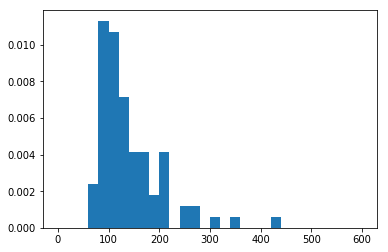

in gaus [160.1552489574406, 220.89887662180715, 100.96094631219152, 133.3697500528421, 92.90382828620365, 135.4923928862131, 277.38701173885596, 90.37914784183293, 361.62937181267273, 86.92367816222992, 356.59782673502707, 121.70434904710241, 154.7034164659897, 74.17356123152383, 129.27839186410256, 101.5372620703162, 201.70088194960323, 216.25023653437987, 102.16912956488595, 94.02325486606627, 119.34401660024434, 123.7708196511119, 90.98871825934303, 104.67269901411188, 137.92691715068955, 91.16245230851501, 134.69572974321264, 166.11860848329064, 226.28786859547077, 128.2281050780122, 162.73392731189878, 283.7785740410336, 83.36353843205502, 107.785048180136, 144.32252421367917, 115.75760505819414, 183.79424069919446, 259.9983244037253, 100.04729224621948, 136.32790169674433, 214.93808171378262, 318.54975080068414, 110.05041753008739, 86.5283301929809, 129.0214617142079, 98.4000649269306, 206.79350519092228, 129.09804382929786, 88.72187267092517, 139.36532836766338, 100.817057844013

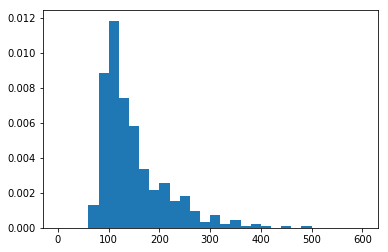

in gaus [123.50391030502155, 287.87857537469955, 397.6400474075308, 194.8806850786713, 131.55979471088844, 105.92810294405595, 126.55224343984173, 144.32370937064627, 124.7190101858, 92.32253925042653, 142.09396705836474, 170.6923371723728, 164.51619331993396, 240.42505116164236, 88.20751895408152, 98.02312712473926, 109.51016637417338, 101.60083647858782, 193.70510613314218, 157.76629873351402, 140.07901056152824, 92.24483130152662, 111.12975434740557, 106.15664943511752, 140.764223035905, 119.5705927654408, 165.26287407844697, 91.22703526894, 158.20044775331482, 121.62777616973926, 161.91222329841304, 121.55574002940723, 90.03904988955591, 111.14763393104181, 117.27304459517968, 113.59775554210947, 86.97211868118511, 191.69317863107642, 89.4524688734645, 140.16513988647074, 289.73422800202934, 199.827191717016, 180.32781753777476, 337.0017485407249, 165.1620252100564, 112.00503456579125, 102.4985637874462, 106.80139515543516, 325.56986554395115, 259.55903495505714, 92.97214419651091,

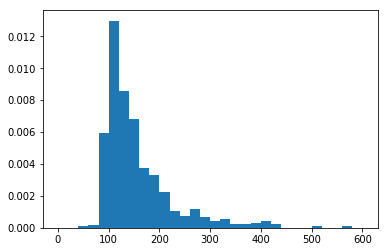

in gaus [139.57583326976848, 335.86626878418616, 515.3399994450161, 168.48469084650415, 230.14182311600587, 258.41177781507525, 131.78205423520595, 206.85244028489296, 165.34364172152056, 134.91945757775022, 137.83181719367101, 131.2483230625784, 155.32490954794696, 232.6892702539044, 115.36703334586745, 259.4429776233569, 210.3763625997768, 148.3932403698419, 137.4946909105174, 167.52352866422515, 118.70411764947292, 136.510308104564, 118.046756105853, 125.79846509581, 153.85700184507175, 116.30726506048096, 111.79412288196676, 235.02990441405043, 159.35780522693116, 147.93393965562774, 214.87737789833122, 142.1838371966747, 386.21800034416543, 125.35230790942475, 303.1561245404733, 120.47091837959795, 130.7870360331968, 143.52244700484826, 123.07781501789523, 262.79482087430506, 137.15611734005918, 134.05440113975743, 220.0223198484428, 137.76285023168694, 118.91349852798831, 158.47779050198648, 266.76632124871185, 115.328087409015, 100.64022497768437, 226.64889067816813, 148.7358619

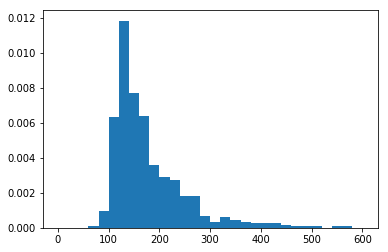

in gaus [238.18336912152083, 101.18013460862988, 135.7902581518446, 223.34574753135297, 153.06951290947458, 126.77149401371479, 166.22115346410135, 204.0137083001929, 358.73987506813467, 196.34456508337877, 166.99846860987472, 236.52854001391069, 165.37745030020238, 136.09830545492122, 182.40612320480395, 321.4142346706637, 327.1846459943083, 138.73068883024993, 124.27413776690933, 140.76464450258928, 188.66788515426475, 162.0645600675853, 171.81238347107845, 200.65321503881358, 199.4071211908641, 355.2774121457854, 153.03375200015836, 156.9944070845501, 139.7476919445363, 258.65031311715586, 255.85259779438567, 179.54667857134376, 118.354574383752, 174.95029138607873, 137.89002928029333, 119.73274534881249, 113.81293036448118, 124.42899752570305, 155.57464979567945, 88.51775241704904, 184.2791830551707, 97.59708016762818, 170.86359617338925, 187.86652911580978, 299.60747040054696, 131.0591638853708, 272.0621291401275, 343.69911354483304, 208.70088021985953, 231.2689731366166, 213.1497

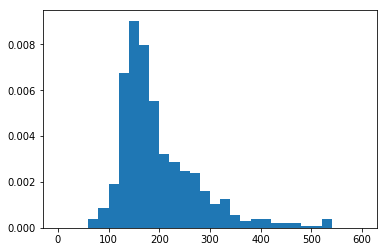

in gaus [173.8704285504069, 160.55099875689925, 156.03045967517278, 362.8581728979589, 181.33357993294302, 180.0023162341196, 194.43764671913502, 216.44881403285038, 195.7498157283772, 218.15157064532437, 148.40681587591547, 257.30947562237725, 147.14901992549525, 171.96942682992622, 158.61657686916658, 297.96007907662266, 201.2030933630336, 215.09856466832682, 235.3010372476084, 222.28927143592898, 153.82015102824568, 160.23398649180342, 174.44875136958714, 185.64426562610026, 143.33942349740298, 261.07962403017586, 125.61353868042869, 235.87057205041805, 174.73569445100532, 167.96718725441775, 196.7957095119826, 271.87418662533656, 188.18120671010382, 140.53438195540727, 212.72837572058776, 428.15557608962627, 171.22690688502274, 222.94193591143866, 92.83220588678192, 154.43456812424, 171.5423998429746, 166.06244156838963, 310.1759595643727, 174.74651870351715, 94.77357942201574, 347.4681076444254, 270.72531474723814, 211.77169804645087, 524.9082042790203, 238.12993504961125, 135.592

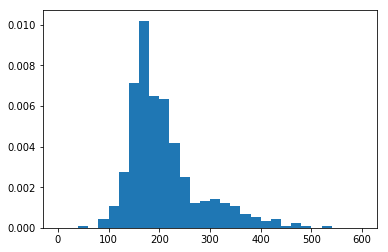

in gaus [369.72368514373795, 174.35578934347555, 237.95774035353077, 242.48922229893873, 218.6159514190209, 204.07450635773398, 253.06245298222797, 189.3471400765062, 207.21536334142397, 83.30950507069218, 266.25610936965705, 416.4806443531226, 257.29669931342823, 180.59075115794695, 299.0041839647956, 233.64799889860774, 324.74991746560625, 188.10473617264347, 315.5828268926421, 125.642180740723, 203.31279989577186, 315.4050344419181, 179.51315726835003, 307.07485535491287, 256.485723611415, 300.8882417049024, 281.3805123960581, 290.1902497534851, 212.67669459614604, 167.35587947043365, 276.3506606518906, 183.64153296350392, 273.24093326372366, 184.06535783022017, 211.3888381178303, 146.86602854683545, 130.7268661608233, 193.84287558735073, 222.40747749770134, 245.9538588088776, 162.1947885692595, 357.69138949393454, 293.12347631240374, 223.62880891942055, 206.670748025351, 202.9610623243467, 188.67216193267683, 190.01375897277143, 241.0474662468964, 243.26423798491336, 207.0218257711

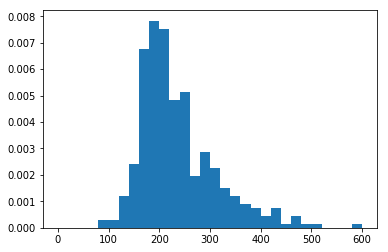

in gaus [191.70310239945644, 189.83816521437822, 205.6724343975312, 417.2160807285859, 201.75073664017773, 381.7704776196021, 241.44574592311292, 244.27819172646113, 215.07636247374765, 328.7579542689088, 184.20909948193764, 268.0497675400631, 333.51829332559106, 260.42439329728245, 115.64755759367247, 111.73346636220923, 161.19892147581146, 292.1893906668596, 228.60119081970288, 199.70235753644593, 248.89425122465028, 239.10211084735602, 357.45042928739855, 285.2602528648092, 223.6146183729021, 203.01599220504116, 227.7139454964856, 181.3755211445517, 127.79043281412247, 231.2205562009889, 229.84571669710502, 201.57274327639576, 177.71422295079165, 225.45818790433088, 304.6845325265999, 186.9012820007293, 228.52013930083086, 212.76244446008997, 284.02116220835717, 276.306469003201, 234.23191203465475, 255.59584162696464, 234.07543929676268, 130.57973536094875, 235.61709223942842, 262.8307853684521, 235.14431839885947, 188.87864658596263, 237.05670604424054, 263.29712200397034, 154.700

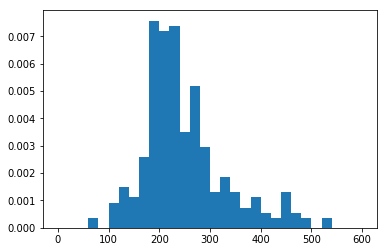

in gaus [219.5057078973666, 184.39964207062667, 258.10439814006844, 204.63160641165862, 325.8432422099904, 232.41034984326805, 101.03133319537835, 209.82835323577973, 208.93301461989347, 507.786287550446, 546.3651418196425, 207.5951778711758, 228.05650999677476, 230.12836008920104, 350.9211241395802, 524.1881716656006, 277.5774106310891, 228.2229558923935, 239.86651904174036, 230.81719690936592, 270.81347350618034, 225.01196140150617, 395.7088716486441, 230.23640614611264, 328.6347747742489, 203.32281133486157, 398.9815904258446, 271.56278447015876, 291.2819622329177, 318.0642595125623, 294.56305273402097, 203.52552456974013, 256.8979092279751, 309.30100993121323, 224.5807556493354, 397.6614449057343, 207.90537961272307, 219.9087728225141, 222.8663817588829, 314.56286236214635, 167.7062651311309, 223.66876083283728, 272.54720907898997, 205.1512156654269, 237.40988782886893, 216.57184608643547, 723.7143112452095, 218.16908643771401, 240.56973791516194, 226.1491685429118, 228.93670684221

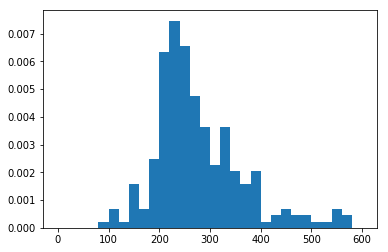

in gaus [302.1108353293539, 226.98390722292046, 225.4898829759921, 242.09229367925556, 233.42006728703348, 225.31977794652138, 225.00851679196225, 286.24631964919735, 356.6783506540174, 305.18666069726805, 243.87142359955914, 280.09388282598604, 243.13873936709322, 352.12904037597986, 289.56128182099155, 109.1565297266766, 166.08366131149657, 241.25400594553008, 367.51711874961103, 252.70150397309848, 236.8782924847204, 507.9279828725195, 210.08128960199832, 311.4199494403621, 281.0663167232426, 291.548208817029, 320.35183103945263, 301.7590643342075, 240.41853280754825, 323.2179726300666, 244.4549321823954, 236.6957618812375, 268.0796353315003, 232.06635063509958, 333.6061644533087, 302.0770418297063, 608.1245331265444, 268.6996709446898, 414.9682709935782, 268.59903242731167, 271.5542768777166, 329.2276977219264, 259.333237357653, 399.66261423541647, 248.564335542117, 462.38025556115355, 216.59126490271223, 293.41966703037644, 369.043939137373, 407.7715463980863, 242.64733723945318, 

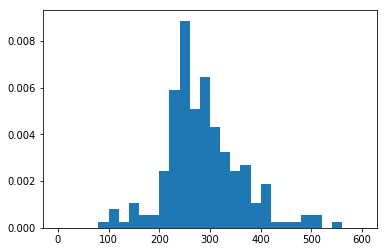

in gaus [277.2056972249552, 307.75600024548527, 259.6928157391066, 271.297085463024, 243.1153954581518, 325.07759402979855, 319.23256585378186, 290.9795658471509, 238.5877781024737, 244.0646815854737, 396.4972699238609, 271.464388637386, 411.43846119980003, 349.57289052487226, 268.6852639307662, 384.00963039158813, 250.32380931055553, 299.84127345320167, 341.0567254323208, 273.33802363395597, 344.30845562772015, 255.84186425949306, 263.5624842871871, 311.71813052570366, 240.9309057599151, 380.8158384673949, 292.9591031769516, 256.07625883124786, 192.26392426618466, 221.18759476838238, 314.93710227751313, 207.66693079259107, 390.21712807860507, 239.35643544655636, 287.3430260116309, 276.13893232638475, 263.87105155748947, 206.26105584446003, 701.4548666585537, 257.7913643530071, 361.6122342912962, 281.60197144395937, 238.60223359573496, 295.08704692598786, 273.4965757955764, 367.2406214989409, 262.91695372576595, 317.5547291284101, 328.0387589447668, 446.71789333633313, 300.788781114128

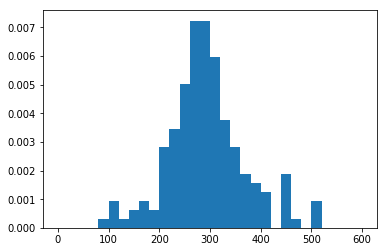

in gaus [553.6698268160894, 272.7820692549739, 346.67984859544885, 335.9435156199769, 310.953552213144, 347.18082142026475, 282.0605263692656, 713.7885656290131, 392.0416389886366, 348.9121743697181, 479.4588782066021, 262.4536426392283, 321.7022167632329, 223.19604663344876, 284.82219033298804, 296.01381303093245, 253.8075388716463, 289.94956691370703, 329.72952662454696, 364.9087318116728, 278.61240852829206, 325.10634592381524, 382.27283867039307, 295.69233903256224, 160.70532789315703, 392.6619261679297, 251.87664604589304, 652.3395518812067, 280.2655380932774, 308.0149933180658, 311.2682884547237, 230.3417016458849, 284.01721183395296, 261.1155125241868, 413.53195693892576, 261.1651082340948, 288.1011207125427, 278.7687109614684, 207.3960318160224, 304.5354941827642, 345.0458519417286, 344.3020703029039, 293.7080186333792, 275.6175163065233, 354.9433257541765, 794.4860994931339, 264.6716600077177, 354.37753076969454, 315.81794862999595, 346.4670860258504, 420.4706093242187, 287.16

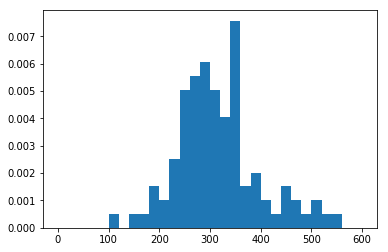

in gaus [342.32745685688855, 327.6066524739876, 427.4327388513905, 303.22530944255834, 686.7546958627084, 448.36387727974005, 599.5384126309939, 412.37158412637615, 272.5568641258659, 643.3801287388347, 313.0228019572166, 227.31260408859424, 231.2504208667677, 205.77117608874025, 369.08000105063553, 401.912184750568, 310.3549428828925, 366.52781314221113, 339.15457625560424, 195.67904708329038, 279.7678368823328, 212.72378493932476, 353.88925404128423, 294.6094128317199, 264.77019967772577, 465.38231451711545, 408.29704643385895, 373.23086316197504, 113.78288300519547, 510.80567211481133, 182.59482670692714, 458.30115268280383, 354.3767615672846, 579.3640729622267, 316.408952583247, 309.5313059164211, 357.8974173216936, 335.9865978348373, 379.4860326677981, 300.32649390574176, 334.66430160513147, 317.53037756363085, 286.0402735854598, 291.3711080247198, 278.82310122025945, 270.48181117019533, 134.62475377785324, 373.4113705996034, 487.134477318515, 294.74618653525863, 329.8204397997896

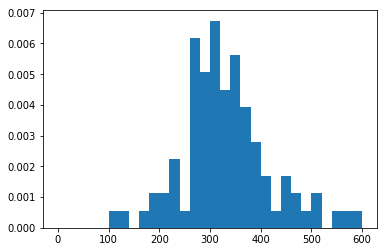

in gaus [363.2080934064678, 821.9697156762217, 381.93549685470185, 374.9281378301031, 433.7934268035513, 306.9242824176402, 658.3315215040917, 690.1406729644634, 476.99657214533016, 230.1583562265825, 346.0856240986405, 273.9800964719236, 415.8847754667628, 122.90609257463333, 479.8564145928962, 301.3741899265705, 446.7952744228974, 176.75320701592167, 392.9710072373628, 412.2462049535141, 362.7769652037956, 291.2348448373405, 211.93215749137644, 305.79885912534417, 385.3171080610996, 464.7623647397102, 370.599030127278, 290.2621206143458, 308.0059328121183, 427.3677039636252, 359.0849852219202, 453.5225181398851, 364.1383361813536, 120.07093144756053, 326.48826696380695, 355.9275049648543, 404.73240687722415, 274.8333999215272, 494.91940450589914, 269.547360850769, 340.9357362961105, 284.07788553415986, 362.49149467034897, 482.3557942704297, 311.9130430030376, 581.3729424453879, 327.65775909501866, 300.27187074023453, 351.63651256040083, 242.60386915843878, 573.3569913599898, 570.8541

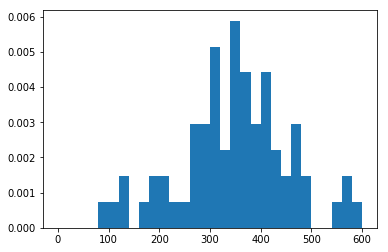

in gaus [464.0373386818872, 1328.8942271156288, 405.24519255684504, 416.84858613173617, 508.1772172689097, 390.38875739857616, 317.58366698665793, 334.9034545610684, 291.11595624262293, 321.60263625817254, 405.73422876831665, 438.069070517503, 134.4890955596482, 225.7064419807163, 277.1208123177623, 348.9848854891116, 352.29895007842896, 378.7862170586201, 334.8357134686893, 398.5139896200373, 358.6752244275606, 334.4014437780566, 524.3273611398486, 316.1768469468918, 168.97737340075548, 357.50899856065985, 334.4210233737252, 500.23457780621396, 379.6264721663148, 308.6309058204548, 409.7625069585568, 381.18817887175754, 326.4061556230796, 399.02307764175225, 92.80602904803246, 133.05664116548553, 382.25220046560105, 401.66597066103145, 310.64673832705887, 458.13651199425914, 407.24704214022694, 365.11214153704657, 417.27520274634827, 438.7708888106321, 358.9986436803402, 587.0997690239616, 358.01763332018504, 376.1808803989243, 394.49403809985847, 177.72020332263153, 520.3944277395998

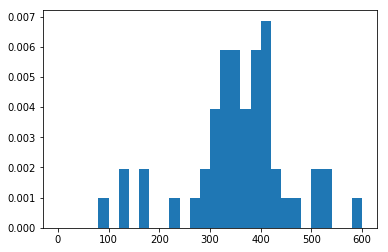

in gaus [405.1030797499539, 368.15827785734933, 438.5349696830352, 424.2721394083419, 485.87385051281626, 545.8256342593534, 427.64815247276385, 374.18372798303886, 427.0869599509857, 231.5656785041563, 655.8567921810632, 471.67449816181403, 688.4471994746617, 374.25359452060144, 370.4474781156056, 403.14192184214016, 505.1041171689756, 198.37211405816996, 353.08411466594237, 340.35148804651016, 348.7762277662798, 563.0469060940327, 323.90339422349206, 320.6696295781882, 323.44981875573086, 449.5241216094837, 345.2937209905925, 310.1745253457681, 348.0074900624031, 473.4561573680206, 472.21114137439554, 663.1957027368755, 486.9181788082476, 296.19996015805157, 335.00735992694393, 452.8844833996587, 269.4520886626835, 493.61441880899946]


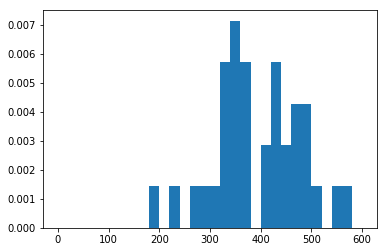

in gaus [481.39175327376444, 425.7103535836558, 616.0991027192922, 494.7183548246892, 386.6391781765621, 507.36495192827226, 525.3532163042141, 408.8765858466185, 874.173269451164, 469.95982537482837, 298.7408413109487, 495.0262433345109, 356.15927266642694, 368.5023658378687, 369.68224777983994, 323.1004997082691, 329.8476168056246, 371.1851373115855, 403.0882569041668, 193.28563515778148, 268.41759003557564, 390.1057480333899, 842.5456903966445, 508.6598974301769, 456.01263488041906, 323.1496927702656, 450.28360484827385, 488.3612630725868, 313.9397987109471, 374.30178201396734, 434.2170117536948, 795.9140433581272, 544.2538600288001, 451.12900293036336, 500.5565227402562, 449.72392215012604, 370.5245621514874, 311.8222332323347]


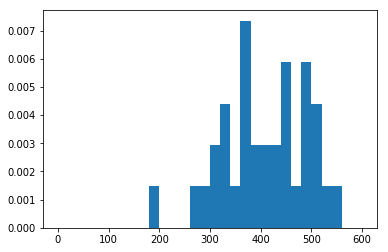

in gaus [481.88769097181586, 410.3972089298626, 615.7721053178909, 428.041448858261, 459.11579633472616, 512.9011355574314, 416.4189297037041, 459.44833052838874, 469.2518487604041, 431.8558101047834, 389.4700935258976, 437.03705710001975, 567.9132986407793, 465.91947057844845, 619.9891660215844, 248.54985564595054, 465.01649082341845, 486.6884982252117, 389.3335499779357, 639.8304064075421, 559.5963870587207, 319.13362268149433, 1847.072112489029]


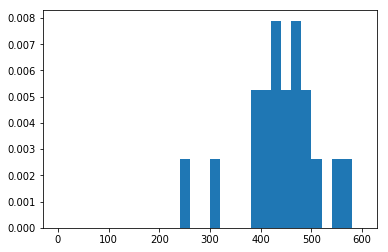

in gaus [591.1940961513036, 293.5787811244727, 398.8508790637201, 633.7721667878483, 1090.6248219586737, 662.6819439525941, 514.6794797846749, 960.6582582699851, 436.6420335996178, 421.4831109202754, 313.2287289376487, 338.02988468002417, 491.37262212028793, 133.54764556829699, 811.2394028245333, 417.5319900077168, 358.6603536501764, 566.5076933094352, 498.87296637512776, 453.00082646876575]


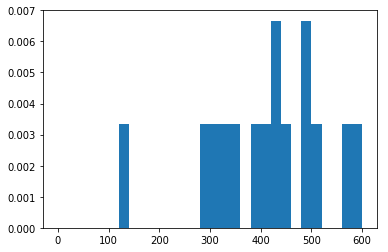

in gaus [435.3179752094999, 493.7937081405747, 523.0614704925104, 1132.8086363857817, 517.8751013145048, 523.7738075669395, 619.2203924949969, 505.6857602874252, 306.4545402537034, 368.5438819667949, 536.8646034759051, 422.6077111820229, 448.76701732823943, 377.1371535161275]


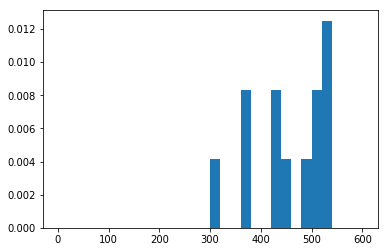

[0.01252171]


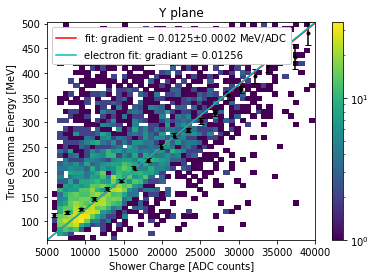

0.012521709817384877


In [157]:
##### windowFrac = 1.0
adcMin = 5000
adcMax = 40000
eMax = 600
print('Window fraction:',windowFrac)
print('ADC fit range:',adcMin,adcMax)
print('Emax:',eMax)

save_str = 'AllImages'

err_multiplier = {'Y':np.sqrt(263.44/19)}


for sumQarr,plane,eMax,finalCal in zip([gamma_lead_recoQ_v],['Y'],[eMax],[0.01319672]):
    print(np.array(sumQarr))
    print(np.array(gamma_lead_trueE_v))
    x,y,err = plotGausFitHist(np.array(sumQarr),np.array(gamma_lead_trueE_v),eMax,'','orange',windowFrac,adcMin,adcMax,False,1.0)#err_multiplier[plane])
    plt.hist2d(sumQarr,gamma_lead_trueE_v,bins=50,range=((5000,40000),(5000*0.01256,40000*0.01256)),norm=LogNorm())
    popt,pcov = curve_fit(line2,x,y,sigma=err)
    print(popt)
    xline = np.arange(0,8e4,100)
    #plt.plot(x,line(x,*popt),'r--',label='fit: gradient = %2.4f$\pm$%2.4f MeV/ADC\n     intercept = %2.1f$\pm$%2.2f MeV' % tuple([popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1])]))
    plt.plot(xline,line2(xline,*popt),'r',label='fit: gradient = %2.4f$\pm$%2.4f MeV/ADC' % tuple([popt[0],np.sqrt(pcov[0,0])]))
    plt.plot([5000,40000],[5000*0.01256, 40000*0.01256],'-c',label='electron fit: gradiant = 0.01256')
    #plt.plot(x,poly(x,*popt),'r--',label='fit: a = %2.4f$\pm$%2.4f MeV/ADC\n     b = %2.1f$\pm$%2.2f MeV\n     c = %2.1f$\pm$%2.2f MeV' % tuple([popt[0],
    #                                                                                                                                             np.sqrt(pcov[0,0]),
    #                                                                                                                                             popt[1],
    #                                                                                                                                             np.sqrt(pcov[1,1]),
    #                                                                                                                                             popt[2],
    #                                                                                                                                             np.sqrt(pcov[2,2])]))
    chi2 = 0
    ndf = -1
    for _x,_y,_err in zip(x,y,err):
        chi2 += ((_y - line2(_x,*popt)) / _err)**2
        ndf+=1
#     plt.text(24000,550,r'$\chi^2$ / ndf: %2.2f / %1i'%(chi2,ndf),bbox=dict(facecolor='white', alpha=1.0))
    plt.colorbar()
    plt.legend(framealpha=1.0)
    plt.xlabel('Shower Charge [ADC counts]')
    plt.ylabel('True Gamma Energy [MeV]')
    plt.title(plane+' plane')
    plt.savefig('CalibLine'+plane+'_new_'+save_str+'_GaussianFit.png')
    plt.show()
    
    '''
    x,y,err = plotMPV(np.array(sumQarr),np.array(etruearr_el),eMax,'','orange',windowFrac,adcMin,adcMax)
    plt.hist2d(sumQarr,etruearr_el,bins=50,range=((0,80000),(0,2000)),norm=LogNorm())
    popt,pcov = curve_fit(line2,x,y,sigma=err)
    print(popt)
    xline = np.arange(0,8e4,100)
    plt.plot(xline,line2(xline,*popt),'r',label='fit: gradient = %2.4f$\pm$%2.4f MeV/ADC' % tuple([popt[0],np.sqrt(pcov[0,0])]))
    chi2 = 0
    ndf = -1
    for _x,_y,_err in zip(x,y,err):
        chi2 += ((_y - line2(_x,*popt)) / _err)**2
        ndf+=1
    plt.text(30000,1500,r'$\chi^2$ / ndf: %2.2f / %1i'%(chi2,ndf),bbox=dict(facecolor='white', alpha=1.0))
    plt.colorbar()
    plt.legend(framealpha=1.0)
    plt.xlabel('ADC Sum')
    plt.ylabel('True Electron Energy [MeV]')
    plt.title(plane+' plane')
    plt.savefig('CalibLine'+plane+'_new_'+save_str+'_MPV.png')
    plt.show()
    
    x,y,err = plotGausFitHist(np.array(sumQarr),np.array(etruearr_el),eMax,'','orange',windowFrac,adcMin,adcMax,False)
    plt.hist2d(sumQarr,etruearr_el,bins=50,range=((0,80000),(0,2000)),norm=LogNorm())
    popt = [finalCal]
    pcov = [0.0001]
    print(popt)
    xline = np.arange(0,8e4,100)
    plt.plot(xline,line2(xline,*popt),'r',label='fit: gradient = %2.4f$\pm$%2.4f MeV/ADC' % tuple([popt[0],pcov[0]]))
    chi2 = 0
    ndf = -1
    for _x,_y,_err in zip(x,y,err):
        chi2 += ((_y - line2(_x,*popt)) / _err)**2
        ndf+=1
    plt.text(30000,1500,r'$\chi^2$ / ndf: %2.2f / %1i'%(chi2,ndf),bbox=dict(facecolor='white', alpha=1.0))
    plt.colorbar()
    plt.legend(framealpha=1.0)
    plt.xlabel('ADC Sum')
    plt.ylabel('True Electron Energy [MeV]')
    plt.title(plane+' plane')
    plt.savefig('CalibLine'+plane+'_new_'+save_str+'_FinalFit.png')
    plt.show()
    '''
    print(popt[0])
    

In [61]:
nbins = 50

plt.hist(fracerrorU,range=(-1,1),bins=nbins,histtype='step',label='U plane')
plt.hist(fracerrorV,range=(-1,1),bins=nbins,histtype='step',label='V plane')
plt.hist(fracerrorY,range=(-1,1),bins=nbins,histtype='step',label='Y plane')
plt.legend()
plt.xlabel('(Ereco-Etrue)/Etrue')
plt.grid()
plt.savefig('FracError_PlaneComparison_'+save_str+'_GaussianFit.png')
plt.show()

plt.hist(fracerror1,range=(-1,1),bins=nbins,histtype='step',label='Run 1',normed=1)
plt.hist(fracerror2,range=(-1,1),bins=nbins,histtype='step',label='Run 2',normed=1)
plt.hist(fracerror3,range=(-1,1),bins=nbins,histtype='step',label='Run 3',normed=1)
plt.legend()
plt.xlabel('(Ereco-Etrue)/Etrue')
plt.grid()
plt.savefig('FracError_RunComparison_'+save_str+'_GaussianFit.png')
plt.show()

plt.hist(fracerrorselU,range=(-1,1),bins=nbins,histtype='step',label='U plane')
plt.hist(fracerrorselV,range=(-1,1),bins=nbins,histtype='step',label='V plane')
plt.hist(fracerrorselY,range=(-1,1),bins=nbins,histtype='step',label='Y plane')
plt.legend()
plt.xlabel('(Ereco-Etrue)/Etrue')
plt.grid()
plt.savefig('FracError_PlaneComparison_'+save_str+'_SelectedFit.png')
plt.show()


#plt.hist(fracerrormpvY,range=(-1,1),bins=nbins,histtype='step',label='MPV')
plt.hist(fracerrorselY,range=(-1,1),bins=nbins,histtype='step',label='Updated Fit')
plt.hist(fracerrorY,range=(-1,1),bins=nbins,histtype='step',label='Old Fit')
plt.tight_layout()
plt.legend()
plt.xlabel('(Ereco-Etrue)/Etrue')
plt.grid()
plt.savefig('FracError_SelVsAll_'+save_str+'.png')
plt.show()

Emin = 35
Emax = 1000

bin_centers,means,std_devs,means_err,std_devs_err = plotFracResGausFitHist(etruearr_el,fracerrorY,Emin,Emax)

plt.hist2d(etruearr_el,fracerrorY,bins=50,range=((35,1000),(-1,1)),norm=LogNorm())
plt.errorbar(x=bin_centers,y=means,yerr=std_devs,fmt='o',capthick=2,elinewidth=2,capsize=3,color='red',zorder=2)
plt.errorbar(x=bin_centers,y=means,yerr=std_devs,fmt='o',capthick=4,elinewidth=4,capsize=4,color='black',zorder=1)
plt.colorbar()
plt.xlabel('True Electron Energy [MeV]')
plt.ylabel('(Ereco-Etrue)/Etrue')
plt.title(r'Calibration Using the Full $\nu_e$ Intrinsic Samples')
plt.savefig('FracErrorVsTrue_'+save_str+'_AllGaussianFit.png')
plt.show()


fig, ax1 = plt.subplots()
plt.title(r'Calibration Using the Full $\nu_e$ Intrinsic Samples')
color = 'tab:red'
ax1.set_xlabel('True Electron Energy [MeV]')
ax1.set_ylabel(r'$\mu$', color=color)
ax1.errorbar(x=bin_centers, y=means, yerr=means_err, fmt='o',label='Mean',capsize=3,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$\sigma$', color=color)  # we already handled the x-label with ax1
ax2.errorbar(x=bin_centers, y=std_devs, yerr=std_devs_err, fmt='o',label='Std Dev',capsize=3,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('FracErrorVsTrue_MeansSigs_'+save_str+'_AllGaussianFit.png')
plt.show()

bin_centers,means,std_devs,means_err,std_devs_err = plotFracResGausFitHist(etruearr_el,fracerrorselY,Emin,Emax)

plt.hist2d(etruearr_el,fracerrorselY,bins=50,range=((35,1000),(-1,1)),norm=LogNorm())
plt.errorbar(x=bin_centers,y=means,yerr=std_devs,fmt='o',capthick=2,elinewidth=2,capsize=3,color='red',zorder=2)
plt.errorbar(x=bin_centers,y=means,yerr=std_devs,fmt='o',capthick=4,elinewidth=4,capsize=4,color='black',zorder=1)
plt.colorbar()
plt.xlabel('True Electron Energy [MeV]')
plt.ylabel('(Ereco-Etrue)/Etrue')
plt.title(r'Calibration Using Selected $\nu_e$ Intrinsic Events')
plt.savefig('FracErrorVsTrue_'+save_str+'_SelGaussianFit.png')
plt.show()


fig, ax1 = plt.subplots()
plt.title(r'Calibration Using Selected $\nu_e$ Intrinsic Events')
color = 'tab:red'
ax1.set_xlabel('True Electron Energy [MeV]')
ax1.set_ylabel(r'$\mu$', color=color)
ax1.errorbar(x=bin_centers, y=means, yerr=means_err, fmt='o',label='Mean',capsize=3,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$\sigma$', color=color)  # we already handled the x-label with ax1
ax2.errorbar(x=bin_centers, y=std_devs, yerr=std_devs_err, fmt='o',label='Std Dev',capsize=3,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('FracErrorVsTrue_MeansSigs_'+save_str+'_SelGaussianFit.png')
plt.show()



'''
bin_centers,means,std_devs,means_err,std_devs_err = plotFracResGausFitHist(etruearr_el,fracerrormpvY,Emin,Emax)


plt.title('MPV')
plt.hist2d(etruearr_el,fracerrormpvY,bins=50,range=((35,2000),(-1,1)),norm=LogNorm())
plt.errorbar(x=bin_centers,y=means,yerr=std_devs,fmt='o',capsize=3,color='black')
plt.colorbar()
plt.xlabel('True Electron Energy [MeV]')
plt.ylabel('(Ereco-Etrue)/Etrue')
plt.savefig('FracErrorVsTrue_'+save_str+'_MPV.png')
plt.show()




fig, ax1 = plt.subplots()
plt.title('MPV')
color = 'tab:red'
ax1.set_xlabel('True Electron Energy [MeV]')
ax1.set_ylabel(r'$\mu$', color=color)
ax1.errorbar(x=bin_centers, y=means, yerr=means_err, fmt='o',label='Mean',capsize=3,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$\sigma$', color=color)  # we already handled the x-label with ax1
ax2.errorbar(x=bin_centers, y=std_devs, yerr=std_devs_err, fmt='o',label='Std Dev',capsize=3,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('FracErrorVsTrue_MeansSigs_'+save_str+'_MPV.png')
plt.show()
'''

NameError: name 'fracerrorU' is not defined